<a href="https://colab.research.google.com/github/nnshoshin/projects/blob/main/praktikum_timeseries_shoshin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


## Подготовка

Подгрузим необходимые библиотеки:

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
from time import time 
import seaborn as sn
from matplotlib.widgets import Slider


Откроем полученные данные:

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')

In [ ]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные состоят из двух столбцов. Первый - это дата с шагом в 10 минут, которую нужно перевести из object в Datetime и сделать индексом. Второй - это целевой признак, количество заказов. Пропусков нет.

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True, drop=True)


In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим на монотонность, чтобы исключить потери в данных.

In [ ]:
df.index.is_monotonic

True

Сделаем ресемплирование по 1 часу:

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные готовы к дальнейшему анализу. 

## Анализ

Проведём более глубокий анализ полученных данных:

In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Количество заказов в час колеблется от 0 до 462 со средним значением - 84 заказа в час. 

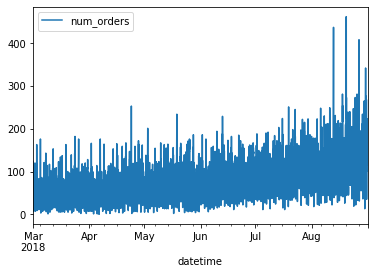

In [ ]:
df.plot()

На почасовом графике на первый взгляд кажется, что количество заказов не менялось с марта по июнь, после чего слегка пошло вверх. В августе наблюдается сильный разброс в значениях. 

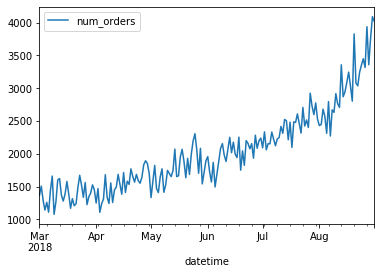

In [ ]:
df.resample('1D').sum().plot()

На дневном графике виден уже более четкий тренд. Видно, что число заказов начало расти уже с апреля.

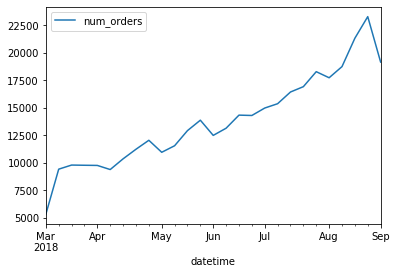

In [ ]:
df.resample('1W').sum().plot()

На недельном графике этот тренд показан еще более четко, но появилось падение на последней неделе августа. Можно предположить, что это связано с концом сезона отпусков.

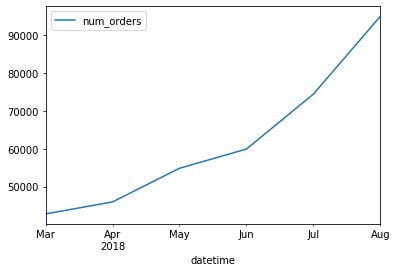

In [ ]:
df.resample('1M').sum().plot()

На месячном графике тренд выглядит наиболее отчетливо. Никаких колебаний на нём не наблюдается.

Разложим наш временной ряд на составляюшие с помощью функции seasonal_decompose() : 

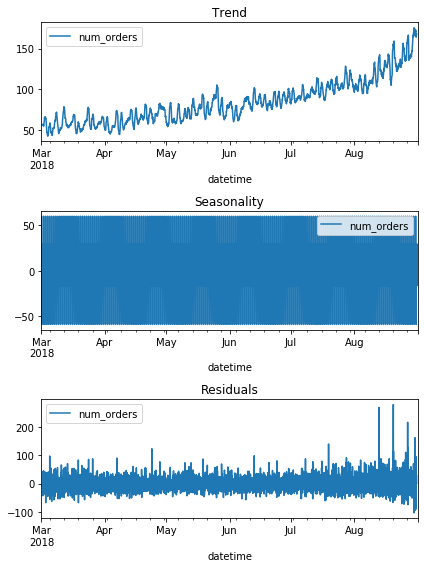

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим, что функция увидела тренд к увеличению числа заказов и увеличение количества выбросов - шумов в августе. Сезонность мы не видим, она слилась в единую полосу, поэтому необходимо увеличить масштаб этой составляющей:

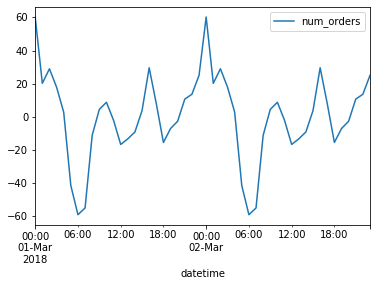

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-2'].plot()

Из графика мы видим, что пик заказов приходится на полночь, а минимумы - стабильно в 06:00.

## Обучение

Приступим к созданию признаков. Выделим все составляющие нашего индекса в отдельные столбцы. "День" был удален из признаков после первичного обучения модели для ускорения работы, так как он показал около-нулевую важность при обучении. 

In [ ]:
#df['month'] = df.index.month
#df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour



Добавим в признаки 24 предыдущих значения(за последние сутки) и скользящее среднее за последнюю неделю, чтобы скормить модели информацию о восходящем тренде. 

In [ ]:
for lag in range(1, 25):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)


df['rolling_mean'] = df['num_orders'].shift().rolling(168).mean()
df.dropna(inplace=True)

In [ ]:
df

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,154.297619
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,154.434524
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.285714


Посмотрим на мультиколлинеарность признаков:

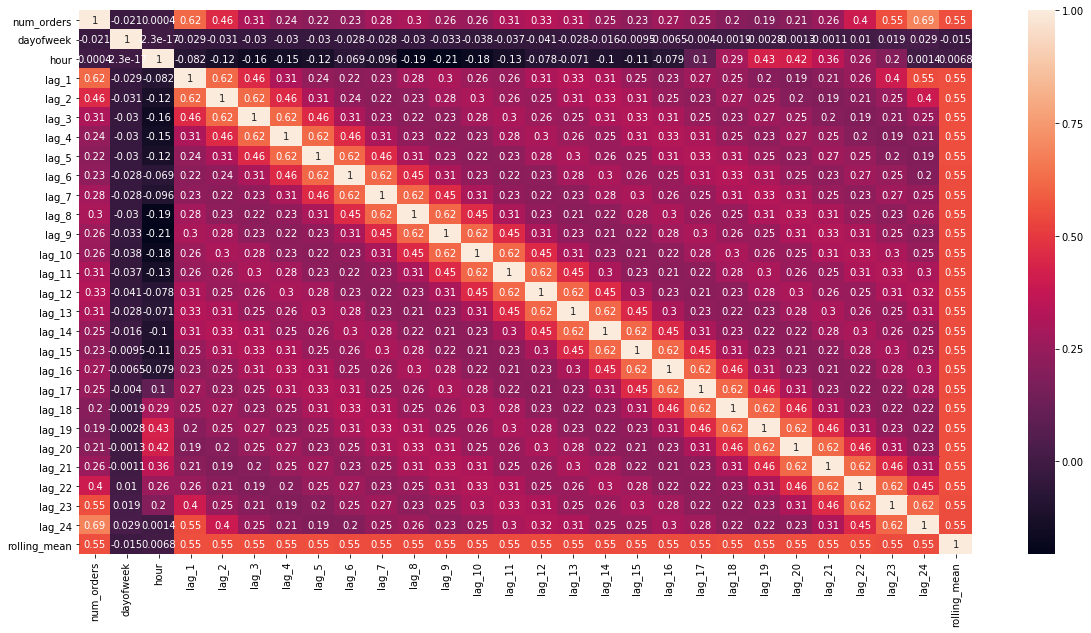

In [ ]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20,10)) 

sn.heatmap(corr_matrix, annot=True)

Видно, что достаточно сильно коррелируют между собой соседние дни. А также скользящее среднее со всеми признаками. Коэффиценты не превышают 0,62, поэтому оставим все как есть. 

Разделим выборки на тренировочную и тестовую:

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())

print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


В этой ячейке я пытался подбирать гиперпараметры для Catboost, но безуспешно. Лучше всего она предсказывала сама по себе без дополнительных вводных))

In [ ]:
#best_lag = 0
#best_rollingsize = 0
#best_model = []
#best_RMSE = 48



#for max_lag in tqdm(range(1,24)):
#    for rolling_size in tqdm(range(1,25)):
#        for lag in tqdm(range(1, max_lag+1)):
#            df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
#            df.dropna(inplace=True)
#            df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
#        df.dropna(inplace=True)
#        train, test = train_test_split(df, shuffle=False, test_size=0.1)
#model = CatBoostRegressor(loss_function='RMSE', has_time=True)
#grid = {'learning_rate': np.arange(0.01, 0.7, 0.01),
#        'depth': np.arange(1,16), 
#        'n_estimators': np.arange(1,15),
#        'l2_leaf_reg': np.arange(1, 10),
#        'random_strength':np.arange(2, 10) 
#       }


#randomized_search_result = model.randomized_search(grid,
#                                                   X=train.drop('num_orders', axis=1),
#                                                   y=train['num_orders'],
#                                                   shuffle=False,
#                                                   train_size = 0.9,
#                                                   n_iter=50,
#                                                   cv=0)


#model.fit(
#train.drop('num_orders', axis=1), train['num_orders'],
#verbose=False,  
#)
#        y_pred = model.predict(test.drop('num_orders', axis=1))
#        rmse = mean_squared_error(test['num_orders'], y_pred)**.5
#        if rmse < best_RMSE:
#            best_model = model
#            best_rollingsize = rolling_size
#            best_lag = max_lag
#            best_RMSE = rmse
            
            
#print(best_lag, best_rollingsize, best_RMSE)
#randomized_search_result

Обучим модель Catboost на наших данных:

In [ ]:
start = time()

model = CatBoostRegressor(loss_function='RMSE')
model.fit(
    train.drop('num_orders', axis=1), train['num_orders'],
    verbose=False)

print( time() - start)


33.386545181274414


Готово. Обучение заняло чуть больше 30 секунд. Проверим важность признаков:

In [ ]:
model.get_feature_importance()

array([ 4.14450583, 16.04267144,  8.39668717,  4.31909744,  2.51130998,
        1.61689301,  1.96318914,  1.89933534,  3.5670236 ,  1.68054912,
        1.72377073,  1.98474666,  1.8156938 ,  2.69589142,  1.88129239,
        1.36095299,  0.99177826,  1.30593159,  3.47467571,  1.49940844,
        1.64626349,  1.62357036,  1.5143116 ,  1.71770854,  3.05404763,
       20.76094541,  4.80774891])

После проверки важности был удален столбец "день", так как он показал околонулевую важность. 

## Тестирование

Протестируем модель на тестовой выборке.

In [ ]:
start = time()
y_pred = model.predict(test.drop('num_orders', axis=1))
print(mean_squared_error(test['num_orders'], y_pred)**.5)
print( time() - start)

40.92312025495807
0.007636547088623047


RMSE составил 40, что удовлетворяет поставленной задаче. 


Объеденим в один датафрейм наши истинные значения, предсказания, разницу между истинным значением и предсказанием и RMSE нарастающим итогом.

In [ ]:
df_results = test['num_orders'].to_frame()

df_results['y_pred'] = y_pred

df_results['difference'] = df_results['num_orders'] - df_results['y_pred']

df_results['rmse'] = 0

for i in df_results.index:
    df_results.loc[i, 'rmse'] = mean_squared_error(df_results[:i]['num_orders'], df_results[:i]['y_pred'])**0.5


df_results




,num_orders,y_pred,difference,rmse
datetime,,,,
2018-08-14 07:00:00,54,53.323991,0.676009,0.676009
2018-08-14 08:00:00,91,93.453370,-2.453370,1.799446
2018-08-14 09:00:00,135,118.254925,16.745075,9.778779
2018-08-14 10:00:00,155,135.419411,19.580589,12.944816
2018-08-14 11:00:00,162,129.052858,32.947142,18.739195
...,...,...,...,...
2018-08-31 19:00:00,136,117.222368,18.777632,40.923899
2018-08-31 20:00:00,154,147.852102,6.147898,40.876478
2018-08-31 21:00:00,159,156.103842,2.896158,40.828374


Построим график на основе полученной таблицы

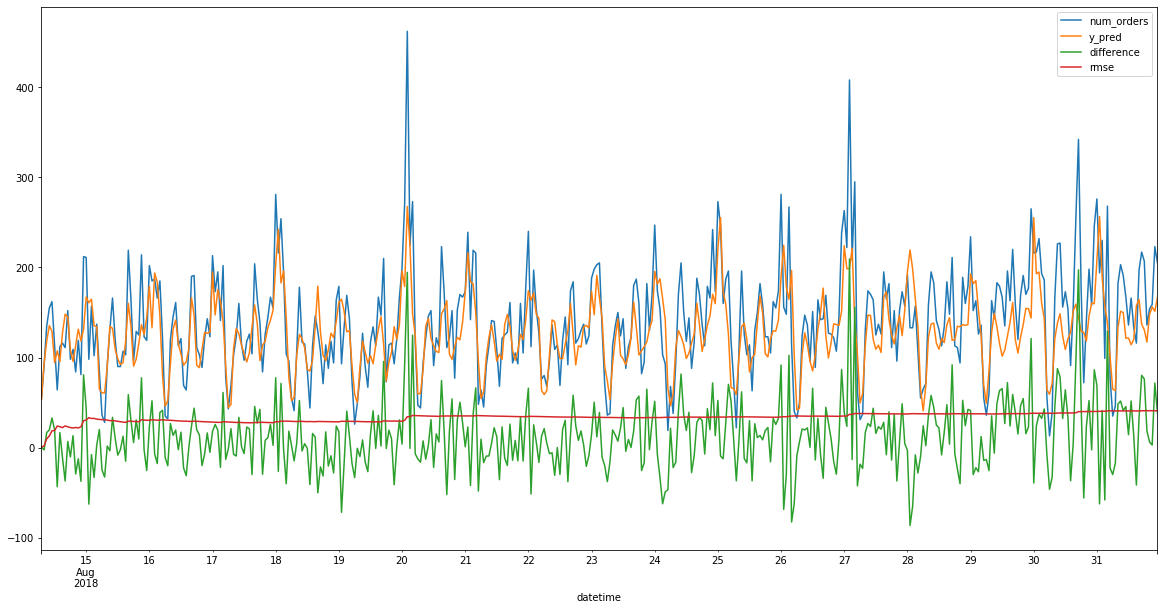

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

df_results.plot(ax=ax)


Из графика мы визуально видим, что в целом наши предсказания неплохо накладываются на истинные значения.Сильные расхождения происходят только в дни с аномально большим количеством заказов, например, 20 августа. 

RMSE дорастает до своего значения к исходу первого дня, далее практически не меняется. 

Взглянем на график в увеличенном масштабе:

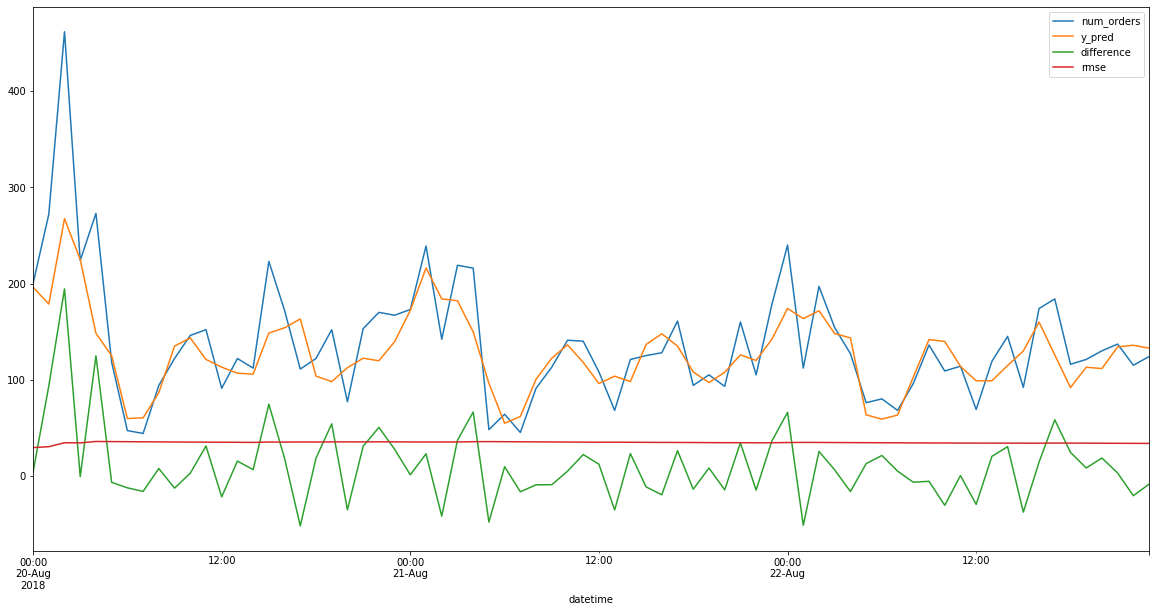

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

df_results['2018-08-20':'2018-08-22'].plot(ax=ax)


Здесь можно сделать теже выводы. RMSE стоит на месте, сильные расхождения только в моменты пиковых значений количества заказов, 20ого августа. В остальном график предсказаний повторяет график истинных значений, немного его сглаживая. 


Проверим модель на адекватность:

In [ ]:
y_pred_median = np.ones(test['num_orders'].shape)*train['num_orders'].median()
y_pred_mean =  np.ones(test['num_orders'].shape)*train['num_orders'].mean()
y_pred_shift = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])

print(mean_squared_error(test['num_orders'], y_pred_median)**.5)
print(mean_squared_error(test['num_orders'], y_pred_mean)**.5)
print(mean_squared_error(test['num_orders'], y_pred_shift)**.5)

87.03915278566916
84.45113423436631
58.819724582830204


Проверка пройдена. RMSE моделей, которые предсказывают средним, медианой и предыдущим значением, сильно выше нашего.

Попробуем сравнить результат с более простыми моделями:

In [ ]:
start = time()
model_linreg = LinearRegression()
model_linreg.fit(train.drop('num_orders', axis=1), train['num_orders'])
y_pred = model_linreg.predict(test.drop('num_orders', axis=1))

print(mean_squared_error(test['num_orders'], y_pred)**.5)
print( time() - start)

44.245031158588965
0.09388017654418945


RMSE получился чуть хуже, на 10% выше, чем на Catboost, но тем не менее линейная регрессия дала результат, удовлетворяющий условию. При этом обучается она практически мгновенно и легко интерпретируема. 

In [ ]:

model_forest = RandomForestRegressor(random_state=12345)
model_forest.fit(train.drop('num_orders', axis=1), train['num_orders'])
y_pred = model_forest.predict(test.drop('num_orders', axis=1))

print(mean_squared_error(test['num_orders'], y_pred)**.5)

45.379833821280776


Лес чуть хуже линейной регрессии, но также выдал приемлимый результат, правда обучался дольше, чем линейная регрессия. 

In [ ]:

model_tree = DecisionTreeRegressor(random_state=12345)
model_tree.fit(train.drop('num_orders', axis=1), train['num_orders'])
y_pred = model_tree.predict(test.drop('num_orders', axis=1))

print(mean_squared_error(test['num_orders'], y_pred)**.5)

59.44278514573786


Дерево решений не справилось с задачей. RMSE сильно хуже того значения, которого нужно было добиться по условию задачи. 

## Вывод

В ходе данного проекта мною была построена модель для прогнозирования числа заказов такси в аэропортах. Условию по допустимому RMSE удовлетворили 2 модели, рекомендовать к дальнейшему применению буду две из них:
- Catboost, если необходима минимизания метрики качества RMSE. Она показала лучший результат со значением 40,8.
- Линейная регрессия, если необходимо быстродействие и интерпретируемость результата. Она показала RMSE равное 44,4. 